<a href="https://colab.research.google.com/github/raultyv/Machine_learning/blob/main/Prediccion_Antawasi_rainfall_Rev1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install contextily pyproj openpyxl pytz

/tmp/ipython-input-3516593296.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dict_factores = comp.groupby('mes').apply(lambda x: x['Estacion'].sum() / x['Modelo_Original'].sum()).to_dict()


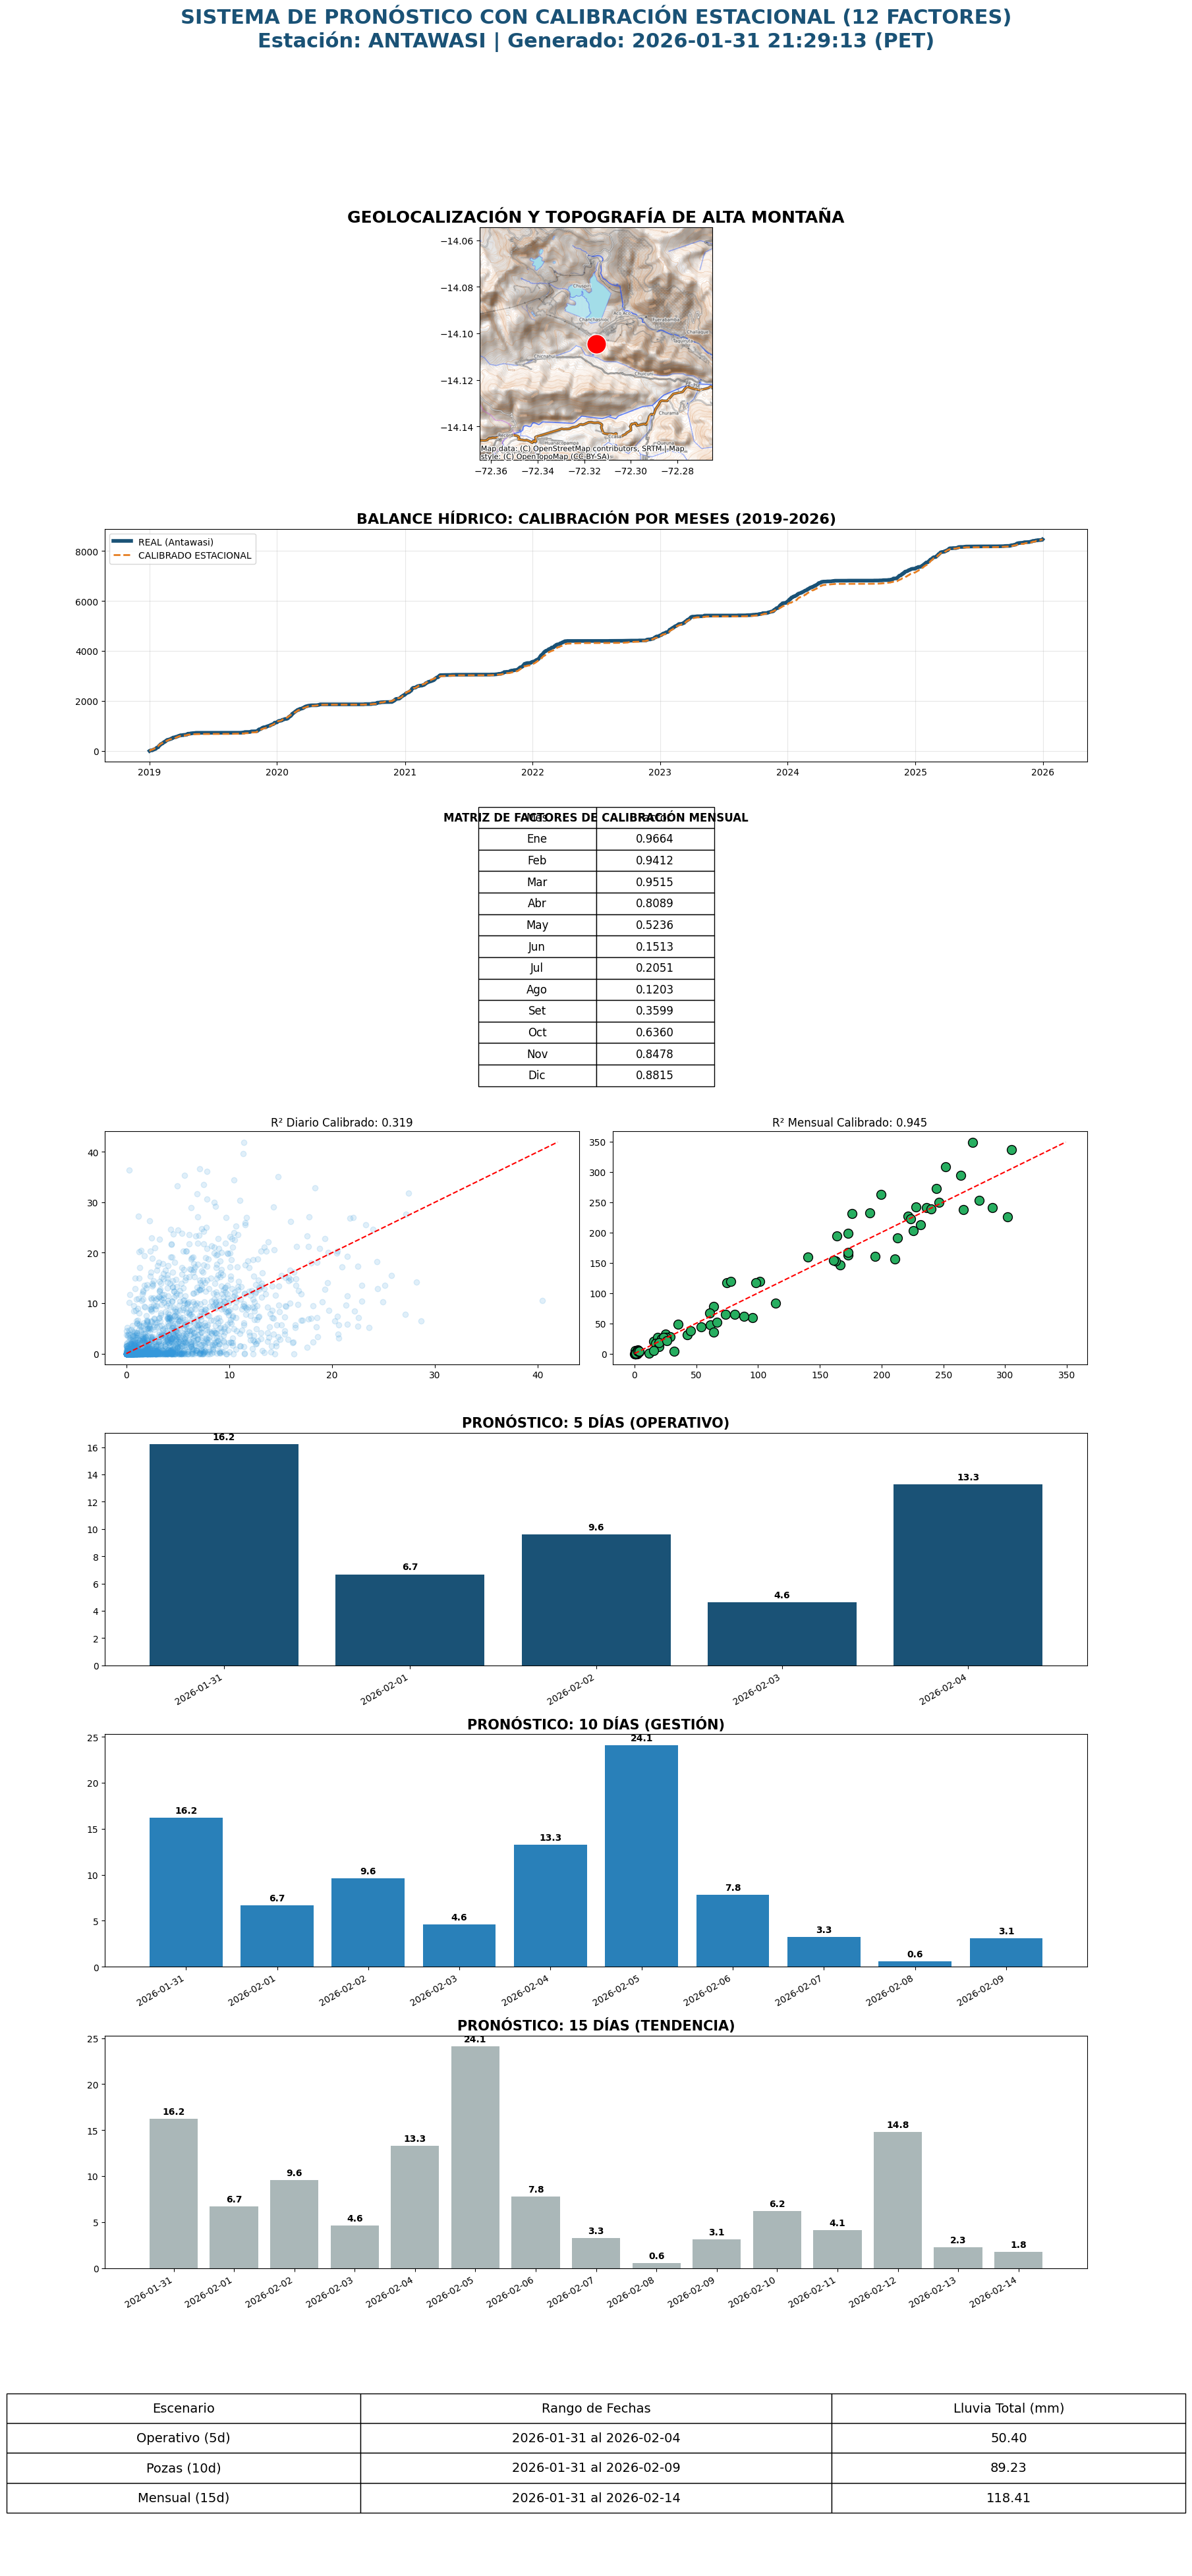

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
import contextily as cx
from sklearn.metrics import r2_score
from datetime import datetime
import pytz

# --- 1. CONFIGURACIÓN DE TIEMPO Y UBICACIÓN ---
tz_peru = pytz.timezone('America/Lima')
ahora_peru_dt = datetime.now(tz_peru)
AHORA_STR = ahora_peru_dt.strftime('%Y-%m-%d %H:%M:%S')
fecha_hoy = ahora_peru_dt.date()

FILE_NAME = 'ANTAWASI.xlsx'
LAT, LON = -14.1045, -72.3149

def obtener_datos(lat, lon, inicio, fin, es_forecast=False):
    tipo = "forecast" if es_forecast else "archive"
    base_url = f"https://api.open-meteo.com/v1/{tipo}" if es_forecast else f"https://archive-api.open-meteo.com/v1/archive"
    params = f"?latitude={lat}&longitude={lon}&hourly=precipitation&timezone=America%2FLima"
    if es_forecast: params += "&forecast_days=15"
    else: params += f"&start_date={inicio}&end_date={fin}"

    r = requests.get(base_url + params).json()
    df = pd.DataFrame({'f': pd.to_datetime(r['hourly']['time']), 'v': r['hourly']['precipitation']})
    df['f_op'] = df['f'] - pd.Timedelta(hours=7) # Corte operativo mina
    return df.groupby(df['f_op'].dt.date)['v'].sum()

try:
    # --- 2. PROCESAMIENTO E HISTÓRICO ---
    df_ex = pd.read_excel(FILE_NAME, header=None, names=['fecha', 'valor'])
    df_ex['fecha'] = pd.to_datetime(df_ex['fecha']).dt.date
    estacion = df_ex.groupby('fecha')['valor'].sum()

    f_ini, f_fin = estacion.index.min().strftime('%Y-%m-%d'), estacion.index.max().strftime('%Y-%m-%d')
    modelo_raw = obtener_datos(LAT, LON, f_ini, f_fin)

    comp = pd.concat([estacion, modelo_raw], axis=1).dropna()
    comp.columns = ['Estacion', 'Modelo_Original']
    comp.index = pd.to_datetime(comp.index)

    # --- 3. CÁLCULO DE 12 FACTORES ESTACIONALES ---
    comp['mes'] = comp.index.month
    # Factor por mes: Sum(Real) / Sum(Modelo) para cada mes del 1 al 12
    dict_factores = comp.groupby('mes').apply(lambda x: x['Estacion'].sum() / x['Modelo_Original'].sum()).to_dict()

    # Aplicar factor correspondiente a cada fila histórica para la curva de masa
    comp['Factor_Mes'] = comp['mes'].map(dict_factores)
    comp['Modelo_Ajustado'] = comp['Modelo_Original'] * comp['Factor_Mes']

    # --- 4. PRONÓSTICO CALIBRADO ESTACIONALMENTE ---
    pred_full = obtener_datos(LAT, LON, None, None, es_forecast=True)
    pred_raw = pred_full[pred_full.index >= fecha_hoy]

    # Aplicar factor según el mes de cada día de pronóstico
    pred_calib = pred_raw.copy()
    for fecha in pred_calib.index:
        mes_f = fecha.month
        pred_calib.loc[fecha] = pred_raw.loc[fecha] * dict_factores.get(mes_f, 1.0)

    # --- 5. PANEL DE CONTROL INTEGRAL ---
    fig = plt.figure(figsize=(18, 70))
    gs = fig.add_gridspec(14, 2)
    fig.suptitle(f"SISTEMA DE PRONÓSTICO CON CALIBRACIÓN ESTACIONAL (12 FACTORES)\nEstación: ANTAWASI | Generado: {AHORA_STR} (PET)",
                 fontsize=22, fontweight='bold', y=0.98, color='#1a5276')

    # 5.1 MAPA 1:1
    ax0 = fig.add_subplot(gs[0, :])
    ax0.scatter([LON], [LAT], color='red', s=450, edgecolors='white', zorder=10)
    delta = 0.05
    ax0.set_xlim(LON - delta, LON + delta); ax0.set_ylim(LAT - delta, LAT + delta)
    ax0.set_aspect('equal')
    cx.add_basemap(ax0, crs='EPSG:4326', source=cx.providers.OpenTopoMap, zoom=13)
    ax0.set_title("GEOLOCALIZACIÓN Y TOPOGRAFÍA DE ALTA MONTAÑA", fontsize=18, fontweight='bold')

    # 5.2 CURVA DE MASA (EL SUSTENTO TÉCNICO)
    ax1 = fig.add_subplot(gs[1, :])
    ax1.plot(comp.index, comp['Estacion'].cumsum(), label='REAL (Antawasi)', color='#1a5276', lw=4)
    ax1.plot(comp.index, comp['Modelo_Ajustado'].cumsum(), label='CALIBRADO ESTACIONAL', color='#e67e22', ls='--', lw=2)
    ax1.set_title('BALANCE HÍDRICO: CALIBRACIÓN POR MESES (2019-2026)', fontsize=16, fontweight='bold')
    ax1.legend(loc='upper left'); ax1.grid(True, alpha=0.3)

    # 5.3 TABLA DE FACTORES ESTACIONALES (NUEVO)
    ax_ft = fig.add_subplot(gs[2, :])
    ax_ft.axis('off')
    meses_nombres = ["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Set", "Oct", "Nov", "Dic"]
    data_f = [[m, f"{dict_factores.get(i+1, 1.0):.4f}"] for i, m in enumerate(meses_nombres)]
    # Dividir en dos columnas para que no sea tan larga
    tabla_f = ax_ft.table(cellText=data_f, colLabels=['Mes', 'Factor'], loc='center', cellLoc='center', colWidths=[0.1, 0.1])
    tabla_f.auto_set_font_size(False); tabla_f.set_fontsize(12); tabla_f.scale(1.2, 1.8)
    ax_ft.set_title("MATRIZ DE FACTORES DE CALIBRACIÓN MENSUAL", fontweight='bold', pad=10)

    # 5.4 SCATTER PLOTS
    ax2 = fig.add_subplot(gs[3, 0])
    ax2.scatter(comp['Modelo_Ajustado'], comp['Estacion'], alpha=0.15, color='#3498db')
    ax2.plot([0, comp['Estacion'].max()], [0, comp['Estacion'].max()], 'r--')
    ax2.set_title(f'R² Diario Calibrado: {r2_score(comp["Estacion"], comp["Modelo_Ajustado"]):.3f}')

    ax3 = fig.add_subplot(gs[3, 1])
    comp_m = comp[['Estacion', 'Modelo_Ajustado']].resample('ME').sum()
    ax3.scatter(comp_m['Modelo_Ajustado'], comp_m['Estacion'], color='#27ae60', s=100, edgecolors='k')
    ax3.plot([0, comp_m['Estacion'].max()], [0, comp_m['Estacion'].max()], 'r--')
    ax3.set_title(f'R² Mensual Calibrado: {r2_score(comp_m["Estacion"], comp_m["Modelo_Ajustado"]):.3f}')

    # 5.5 PRONÓSTICOS
    def autolabel(ax, rects):
        for rect in rects:
            h = rect.get_height()
            if h > 0: ax.annotate(f'{h:.1f}', xy=(rect.get_x() + rect.get_width()/2, h),
                                  xytext=(0, 5), textcoords="offset points", ha='center', fontweight='bold')

    series = [(pred_calib.iloc[:5], '5 DÍAS (OPERATIVO)', '#1a5276'),
              (pred_calib.iloc[:10], '10 DÍAS (GESTIÓN)', '#2980b9'),
              (pred_calib, '15 DÍAS (TENDENCIA)', '#aab7b8')]

    for i, (data, tit, col) in enumerate(series):
        ax = fig.add_subplot(gs[4+i, :])
        bars = ax.bar(data.index.astype(str), data.values, color=col)
        ax.set_title(f'PRONÓSTICO: {tit}', fontweight='bold', fontsize=15)
        autolabel(ax, bars)
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

    # 5.6 TABLA RESUMEN OPERATIVO
    ax_t = fig.add_subplot(gs[7, :])
    ax_t.axis('off')
    resumen = [
        ['Escenario', 'Rango de Fechas', 'Lluvia Total (mm)'],
        ['Operativo (5d)', f"{pred_calib.index[0]} al {pred_calib.index[4]}", f"{pred_calib.iloc[:5].sum():.2f}"],
        ['Pozas (10d)', f"{pred_calib.index[0]} al {pred_calib.index[9]}", f"{pred_calib.iloc[:10].sum():.2f}"],
        ['Mensual (15d)', f"{pred_calib.index[0]} al {pred_calib.index[-1]}", f"{pred_calib.sum():.2f}"]
    ]
    tabla = ax_t.table(cellText=resumen, loc='center', cellLoc='center', colWidths=[0.3, 0.4, 0.3])
    tabla.auto_set_font_size(False); tabla.set_fontsize(14); tabla.scale(1.2, 2.5)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

except Exception as e:
    print(f"Error Crítico: {e}")